In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets, preprocessing, svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline

# Data Preprocessing and Exploration

In [3]:
corpus_df = pd.read_parquet('s2orc_mast_corpus_25oct2022-890.pqt')

In [4]:
mast_complete_clean_original = pd.read_parquet('s2orc_mast_labels_25oct2022-890.pqt')

In [5]:
mast_complete_clean_original.groupby('label_idx').count()

,included,bibcode,publication_date,mission,paper_type,arxiv,mast,year
label_idx,,,,,,,,
0,8118,8118,8118,8118,8118,8118,8118,8118
1,14813,14813,14813,14813,0,14813,14813,14813


In [6]:
mast_complete_clean_original.paper_type.unique()

array([None, 'MENTION', 'SCIENCE', 'DATA_INFLUENCED', 'SUPERMENTION',
       'UNRESOLVED_GREY', 'ENGINEERING', 'INSTRUMENT'], dtype=object)

In [7]:
#Tokenize data by sentences 
corpus=[]
for i in corpus_df['clean_text']:
    add = sent_tokenize(i)
    corpus.append(add)
corpus_df['sentences']=corpus

In [8]:
keywords = ['MAST', 'GALEX', 'Galaxy Evolution Explorer', 'FUSE', 'Far Ultraviolet Spectroscopic Explorer', 'IUE', 'International Ultraviolet Explorer', 'EUVE', 'Extreme Ultraviolet Explorer', 'ORFEUS', 'Orbiting Retrievable Far and Extreme Ultraviolet Spectrometers', 'BEFS', 'Berkeley Extreme and Far-UV Spectrometer', 'Berkeley Spectrometer', 'IMAPS', 'Interstellar Medium Absorption Profile Spectrograph', 'TUES', 'Tubingen Ultraviolet Echelle Spectrometer', 'UIT', 'Ultraviolet Imaging Telescope', 'HUT', 'Hopkins Ultraviolet Telescope', 'WUPPE', 'Wisconsin Ultraviolet Photo-Polarimeter Experiment', 'Copernicus', 'OAO-3', 'Kepler', 'AIDA', 'K2', 'TESS', 'Transiting Exoplanet Survey Satellite', 'K2', 'KTWOCANDELS', 'PANSTARRS', 'Pan-STARRS', 'PAN STARRS', '10.17909', 'PanSTARRS-1', 'Pan-STARRS-1', 'PanSTARRS1', 'Pan-STARRS1', 'PS1']

In [9]:
regexp=re.compile('|'.join(keywords))

In [10]:
#Function to pull out specified sentences
def relevant_sentences(before,after):
    sentences_HST=[]
    for sentences in corpus_df['sentences']:
        sentences_HST.append([])
        for j,y in enumerate(sentences):
            match=regexp.findall(y)
            if len(match)>=1: #or len(match2)>=1:
                sentences_HST[-1].append(y)
                if j>before and j<(len(sentences)-after):
                    sentences_HST[-1].extend(sentences[j-before:j+after])
        sentences_HST[-1]=list(set(sentences_HST[-1]))
    return sentences_HST

In [11]:
sentences_keywords = relevant_sentences(0,0)

In [12]:
corpus_df['sentences_keywords'] = sentences_keywords

In [13]:
#Check length 
corpus = []
for i in corpus_df['sentences_keywords']:
    add = len(i)
    corpus.append(add)
corpus_df['len_MAST']=corpus

In [14]:
mask = corpus_df['len_MAST'] >= 1
sentences_df = corpus_df[mask]

In [15]:
#join all sentences per paper to use in tfidf
corpus=[]
for i,j in enumerate(sentences_df['sentences_keywords']):
    if len(j) >= 1:
        add = ''.join(j)#''.join(j)
        corpus.append(add)
    else:
        add = sentences_df['clean_text'][i]
        corpus.append(add)
sentences_df['joined'] = corpus

/tmp/ipykernel_4115179/3784890861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentences_df['joined'] = corpus


In [16]:
#sentences_df.reset_index(inplace = True)

In [17]:
#sentences_df = sentences_df[sentences_df['len_MAST'] == 0]

In [18]:
#sentences_df.groupby('label').count()[sentences_df['label'] == 0]

In [19]:
cleaned_df = sentences_df[['clean_text','joined', 'label']]
cleaned_df['label'] = sentences_df.label
#cleaned_df.set_index('arxiv_id',inplace = True)

/tmp/ipykernel_4115179/3707832172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['label'] = sentences_df.label


In [21]:
#test with random sample
random_state = 200
holdout = cleaned_df.sample(frac = 0.2, random_state = random_state, axis = 0)
cleaned_df = cleaned_df.loc[~cleaned_df.index.isin(holdout.index)]
mast_complete_clean = mast_complete_clean_original.loc[mast_complete_clean_original.index.isin(cleaned_df.index)]

In [22]:
#cleaned_df.to_hdf('MAST_sentences.h5', key = 'cleaned_df')

In [23]:
#%%timeit
tfidf_vector = TfidfVectorizer(min_df = 0.001, max_df = 0.999,ngram_range = (1,2))
tfidf_vector.fit(cleaned_df['joined'])
X_tfidf = tfidf_vector.transform(cleaned_df['joined'])

In [24]:
full_tfidf = TfidfVectorizer(min_df = 0.001, max_df = 0.999,ngram_range = (1,2))
full_tfidf.fit(cleaned_df['clean_text'])
full_tf = full_tfidf.transform(cleaned_df['clean_text'])

In [25]:
mast_complete_feat = X_tfidf
mast_complete_clean_reduced = cleaned_df

In [26]:
(rf_feat_train, rf_feat_test, 
 rf_label_train, rf_label_test,) = train_test_split(
    mast_complete_feat, mast_complete_clean_reduced.label.values, 
    train_size=0.8, random_state=random_state)

In [27]:
sentences_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_tfidf)
full_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(full_tf)
sentences_embedded.shape,full_embedded.shape         

((11846, 2), (11846, 2))

<Figure size 720x432 with 0 Axes>

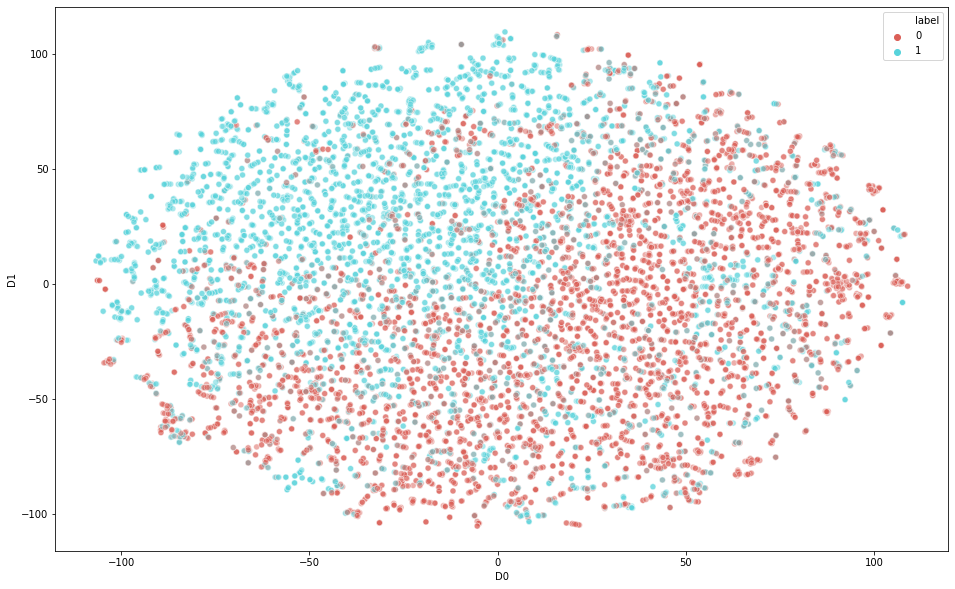

In [49]:
TSNE_full = pd.DataFrame(full_embedded, columns = ['D0','D1'])
TSNE_full['label'] = mast_complete_clean_reduced['label'].to_numpy()
fig = plt.figure(figsize = (10,6))
plt.figure(figsize=(16,10))
full = sns.scatterplot(
    x=TSNE_full.iloc[:,0], y=TSNE_full.iloc[:,1],
    hue = TSNE_full['label'],
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.5
)
fig = full.get_figure()
fig.savefig('TSNE_full.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)

<Figure size 720x432 with 0 Axes>

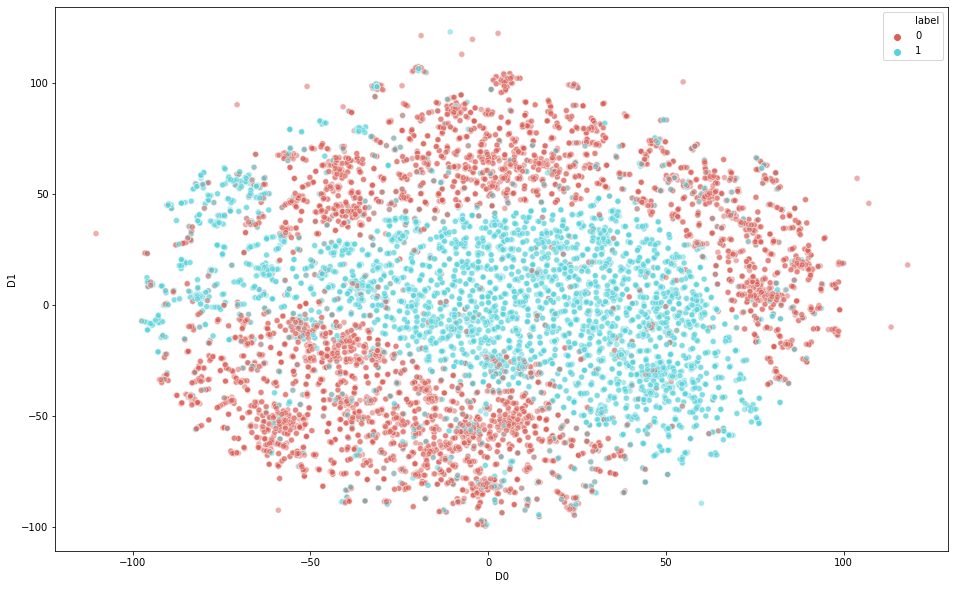

In [48]:
TSNE_df = pd.DataFrame(sentences_embedded, columns = ['D0','D1'])
TSNE_df['label'] = mast_complete_clean_reduced['label'].to_numpy()
fig = plt.figure(figsize = (10,6))
plt.figure(figsize=(16,10))
keywords_tsne = sns.scatterplot(
    x=TSNE_df.iloc[:,0], y=TSNE_df.iloc[:,1],
    hue = TSNE_df['label'],
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.5
)
fig = keywords_tsne.get_figure()
fig.savefig('TSNE_keywords.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)

# Model Development

In [30]:
#%%timeit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, datasets, preprocessing, svm
svm_class = svm.SVC(random_state = random_state, class_weight = {0:.6, 1:.4})
#MLP_class=MLPClassifier(solver = 'adam', activation = 'relu', learning_rate = 'adaptive')
#rf_class = CalibratedClassifierCV(RandomForestClassifier(n_estimators=500,verbose=1, n_jobs=4, min_samples_leaf=10, ))
svm_class.fit(rf_feat_train, rf_label_train)
#MLP_class.fit(rf_feat_train, rf_label_train)
#rf_class.fit(rf_feat_train, rf_label_train)

SVC(class_weight={0: 0.6, 1: 0.4}, random_state=200)

In [31]:
#%%timeit
#predict = svm_class.predict(rf_feat_test)
predict = svm_class.predict(rf_feat_test)
metrics.accuracy_score(predict, rf_label_test)

0.9248945147679325

# Model Analysis

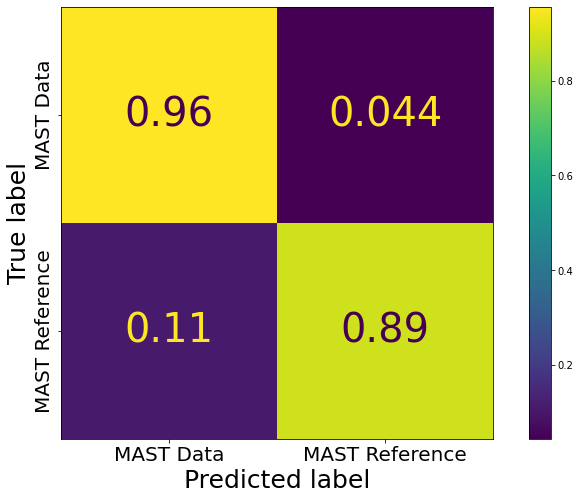

In [32]:
#%pylab notebook
fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0,0,1,1])
ConfusionMatrixDisplay.from_estimator(svm_class, rf_feat_test, rf_label_test, normalize='true', ax = ax)
fig.gca().set_xticklabels(['MAST Data','MAST Reference'],fontsize=20)
fig.gca().set_yticklabels(['MAST Data','MAST Reference'],fontsize=20, rotation='vertical', verticalalignment='center')
fig.gca().yaxis.label.set_size(25)
fig.gca().xaxis.label.set_size(25)
for t in fig.gca().texts:
    t.set_fontsize(40)
fig.savefig('mast_confusion.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)

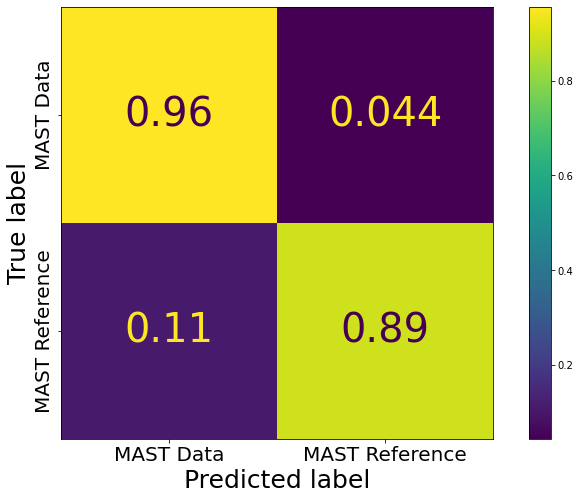

In [33]:
#%pylab notebook
fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0,0,1,1])
ConfusionMatrixDisplay.from_estimator(svm_class, rf_feat_test, rf_label_test, normalize='true', ax = ax)
fig.gca().set_xticklabels(['MAST Data','MAST Reference'],fontsize=20)
fig.gca().set_yticklabels(['MAST Data','MAST Reference'],fontsize=20, rotation='vertical', verticalalignment='center')
fig.gca().yaxis.label.set_size(25)
fig.gca().xaxis.label.set_size(25)
for t in fig.gca().texts:
    t.set_fontsize(40)
fig.savefig('mast_confusion.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)

In [34]:
from sklearn.metrics import f1_score
print(f1_score(rf_label_test, predict, average='macro'))

print(f1_score(rf_label_test, predict, average='micro'))

print(f1_score(rf_label_test, predict, average='weighted'))

0.9244489750305169
0.9248945147679326
0.9247280493715355


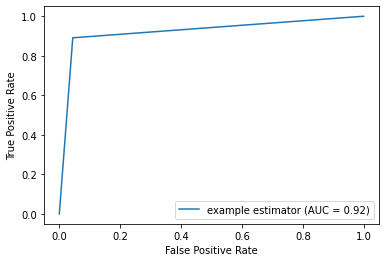

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(rf_label_test, predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

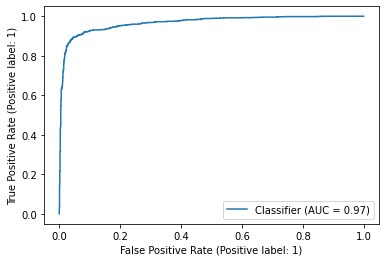

In [36]:
from sklearn.metrics import RocCurveDisplay
y_pred = svm_class.decision_function(rf_feat_test)
RocCurveDisplay.from_predictions(rf_label_test, y_pred)

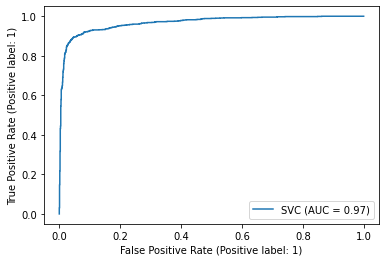

In [37]:
RocCurveDisplay.from_estimator(svm_class, rf_feat_test, rf_label_test)

/tmp/ipykernel_4115179/475766157.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('mast_roc.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)
/home/vicenteamado/.conda/envs/deepthought/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


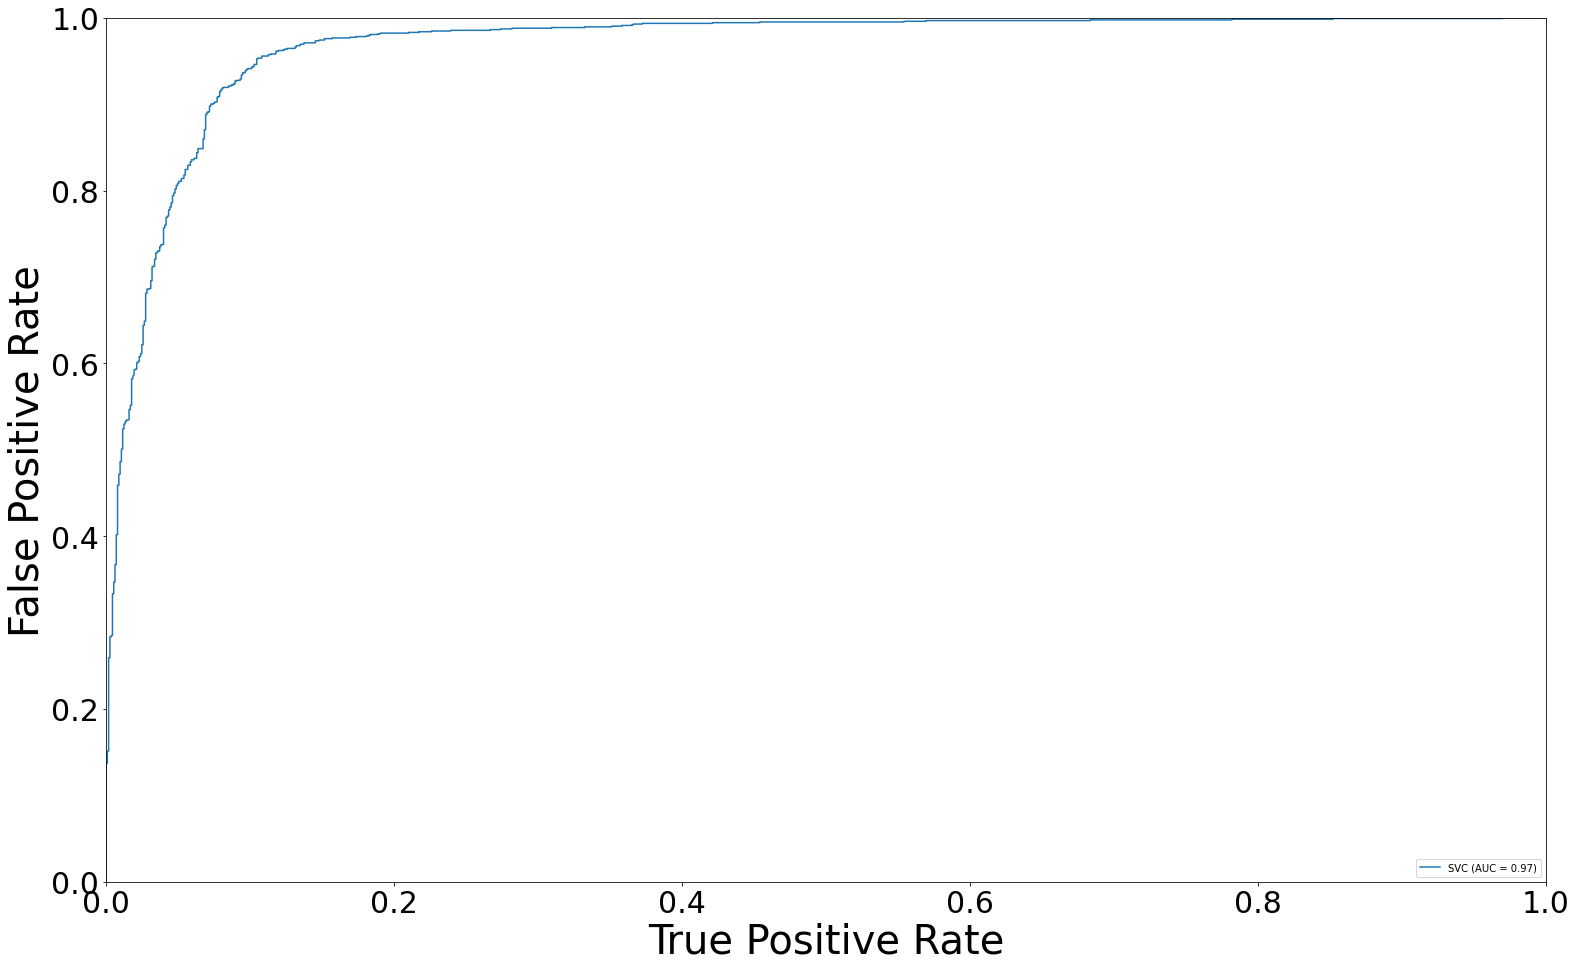

In [38]:
fig = plt.figure(figsize=(20,12), tight_layout=True)
ax = fig.add_axes([0,0,1,1])
RocCurveDisplay.from_estimator(svm_class, rf_feat_test, rf_label_test, pos_label = 0, ax = ax)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
fig.gca().yaxis.label.set_size(40)
fig.gca().xaxis.label.set_size(40)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
for t in fig.gca().texts:
    t.set_fontsize(32)
fig.savefig('mast_roc.pdf',format = 'pdf', dpi = 1000,transparent = False, bbox_inches = "tight", pad_inches = 1)

In [39]:
scores = cross_val_score(svm_class, rf_feat_train, rf_label_train, cv = 10)

In [40]:
np.average(scores)

0.9252824820998132

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
recall_score(rf_label_test, predict, average = 'weighted'), precision_score(rf_label_test, predict)

(0.9248945147679325, 0.9481132075471698)

# Holdout Data Classification . 

In [42]:
holdout_tfidf = tfidf_vector.transform(holdout['joined'])

In [43]:
holdout_predict = svm_class.predict(holdout_tfidf)
metrics.accuracy_score(holdout_predict,holdout.label.values)

0.9247130317353139

# Miscellaneous

In [ ]:
# import pandas as pd
# df=pd.DataFrame(columns=('Doc2Vec','TF-IDF'),data=[[0.761,0.810],[0.853,0.876],[0.838,0.860]])
# vectorization=pd.Series(['Random Forest','Support Vector Machine', 'Deep Neural Network'])
# df=df.set_index(vectorization)
# df

In [ ]:
# important_tokens = pd.DataFrame(
#     data=svm_class.coef_[0].todense().T,
#     index=tfidf_vector.get_feature_names(),
#     columns=['coefficient0']
# ).sort_values(by = 'coefficient0',ascending=False)

In [ ]:
# fig=df.plot(rot=0,kind='bar',figsize=(20, 10),fontsize=30)
# fig.legend(loc=0,prop={'size': 20})
# #fig.set_title('Accuracy for Classification Techniques')
# fig.set_ylabel("Accuracy")
# fig.set_xlabel("Classifiers")
# fig.title.set_size(50)
# fig.xaxis.label.set_size(25)
# fig.yaxis.label.set_size(25)
# fig.figure.savefig('hst_bar.png')